In [37]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pprint

tfk = tf.keras
tfkl = tfk.layers

## Load and preprocess the MNIST dataset

In [2]:
BATCH_SIZE = 512

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

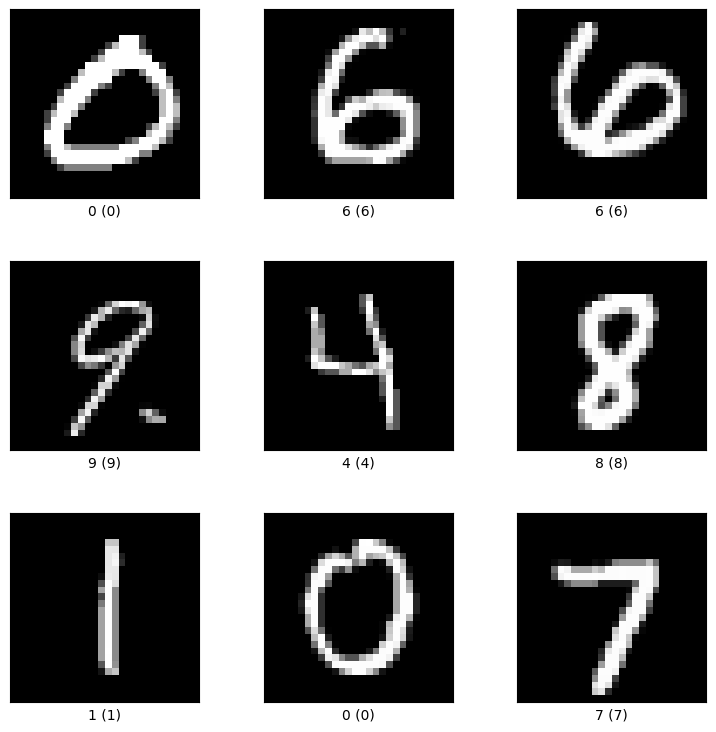

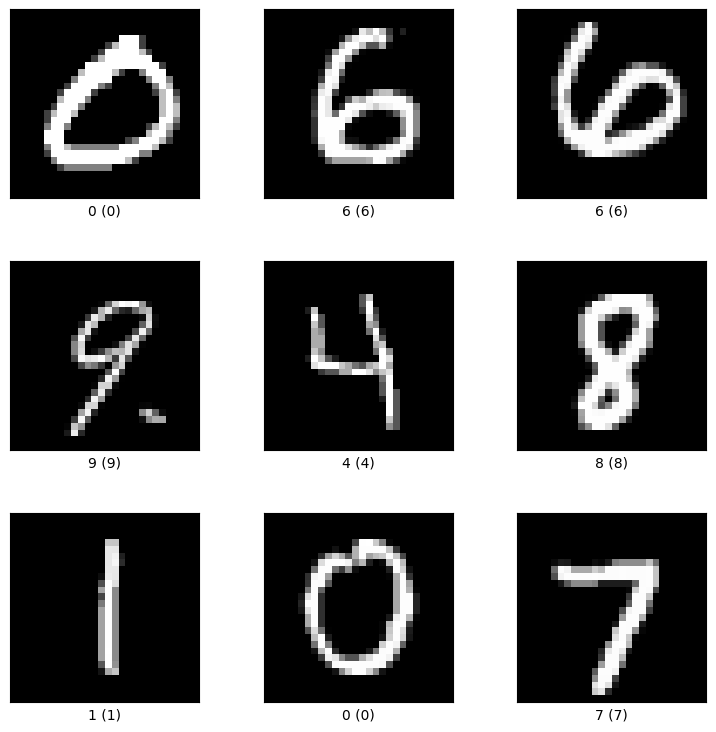

In [4]:
tfds.visualization.show_examples(ds_train, ds_info, is_batched=True)

## Define models

We define a simple MLP as our baseline and a number of KANs.

In [5]:
from arnold.layers.polynomial.orthogonal import (
    Bessel, 
    Chebyshev1st,
    Gegenbauer, 
    Hermite, 
    Jacobi, 
    GeneralizedLaguerre, 
)

from arnold.layers.wavelet import (
    Poisson,
    Ricker,
    Morelet,
    Bump
)

In [28]:
all_models = {
    'mlp': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Dense(784, activation="relu"),
            tfkl.Dense(512, activation="relu"),
            tfkl.Dense(10, activation="softmax")
        ],
        name='mlp'
    ),
    'bessel': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Bessel(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            Bessel(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            Bessel(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="bessel_kan" 
    ),
    'chebyshev_1st': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Chebyshev1st(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            Chebyshev1st(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            Chebyshev1st(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="chebyshev_1st_kan" 
    ),
    'gegenbauer': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Gegenbauer(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            Gegenbauer(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            Gegenbauer(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="gegenbauer_kan" 
    ),
    'hermite': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Hermite(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            Hermite(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            Hermite(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="hermite_kan" 
    ),
    'jacobi': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Jacobi(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            Jacobi(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            Jacobi(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="jacobi_kan" 
    ),
    'generalized_laguerre': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            GeneralizedLaguerre(input_dim=784, output_dim=32, degree=2),
            tfkl.LayerNormalization(),
            GeneralizedLaguerre(input_dim=32, output_dim=16, degree=3),
            tfkl.LayerNormalization(),
            GeneralizedLaguerre(input_dim=16, output_dim=10, degree=2),
            tfkl.Softmax()
        ],
        name="generalized_laguerre_kan" 
    ),
    'poisson': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Poisson(input_dim=784, output_dim=32),
            tfkl.LayerNormalization(),
            Poisson(input_dim=32, output_dim=16),
            tfkl.LayerNormalization(),
            Poisson(input_dim=16, output_dim=10),
            tfkl.Softmax()
        ],
        name="poisson_kan" 
    ),
    'ricker': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Ricker(input_dim=784, output_dim=32),
            tfkl.LayerNormalization(),
            Ricker(input_dim=32, output_dim=16),
            tfkl.LayerNormalization(),
            Ricker(input_dim=16, output_dim=10),
            tfkl.Softmax()
        ],
        name="ricker_kan" 
    ),
    'morelet': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Morelet(input_dim=784, output_dim=32),
            tfkl.LayerNormalization(),
            Morelet(input_dim=32, output_dim=16),
            tfkl.LayerNormalization(),
            Morelet(input_dim=16, output_dim=10),
            tfkl.Softmax()
        ],
        name="morelet_kan" 
    ),
    'bump': tfk.Sequential([
            tfkl.Reshape(target_shape=(784, )),
            tfkl.Rescaling(scale=1./127.5, offset=-1),
            Bump(input_dim=784, output_dim=32),
            tfkl.LayerNormalization(),
            Bump(input_dim=32, output_dim=16),
            tfkl.LayerNormalization(),
            Bump(input_dim=16, output_dim=10),
            tfkl.Softmax()
        ],
        name="bump_kan" 
    ),
}

## Train all models

Build and compile all models. 

In [30]:
for name, model in tqdm(all_models.items()):
    model.build((None, 28, 28, 1))
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print('Trainable parameter', {name: np.sum([np.prod(p.shape) for p in model.trainable_weights]) for (name, model) in all_models.items()})
print('Non-trainable parameter', {name: np.sum([np.prod(p.shape) for p in model.non_trainable_weights]) for (name, model) in all_models.items()})

100%|██████████| 11/11 [00:00<00:00, 397.18it/s]

Trainable parameter {'mlp': 1022490, 'bessel': 77888, 'chebyshev_1st': 77888, 'gegenbauer': 77891.0, 'hermite': 77888, 'jacobi': 77894.0, 'generalized_laguerre': 77891.0, 'poisson': 77376, 'ricker': 77376, 'morelet': 77379.0, 'bump': 77376}
Non-trainable parameter {'mlp': 0.0, 'bessel': 0.0, 'chebyshev_1st': 0.0, 'gegenbauer': 0.0, 'hermite': 0.0, 'jacobi': 0.0, 'generalized_laguerre': 0.0, 'poisson': 0.0, 'ricker': 3.0, 'morelet': 0.0, 'bump': 0.0}


Train all models. On a Apple M1 Max this will take ~5 minutes.

In [31]:
EPOCHS = 10

In [32]:
model_train_histories = {
    name: model.fit(
        ds_train,
        epochs=EPOCHS, 
        shuffle=True,
        verbose=1
    ) for (name, model) in all_models.items()
}

Epoch 1/10
118/118 [==============================] - 1s 11ms/step - loss: 6.2670 - accuracy: 0.8779
Epoch 2/10
118/118 [==============================] - 1s 11ms/step - loss: 0.3297 - accuracy: 0.9560
Epoch 3/10
118/118 [==============================] - 1s 11ms/step - loss: 0.1308 - accuracy: 0.9759
Epoch 4/10
118/118 [==============================] - 1s 11ms/step - loss: 0.0682 - accuracy: 0.9852
Epoch 5/10
118/118 [==============================] - 1s 11ms/step - loss: 0.0364 - accuracy: 0.9906
Epoch 6/10
118/118 [==============================] - 1s 11ms/step - loss: 0.0304 - accuracy: 0.9912
Epoch 7/10
118/118 [==============================] - 1s 11ms/step - loss: 0.0212 - accuracy: 0.9940
Epoch 8/10
118/118 [==============================] - 1s 12ms/step - loss: 0.0204 - accuracy: 0.9944
Epoch 9/10
118/118 [==============================] - 1s 12ms/step - loss: 0.0294 - accuracy: 0.9928
Epoch 10/10
118/118 [==============================] - 2s 13ms/step - loss: 0.0268 - accura

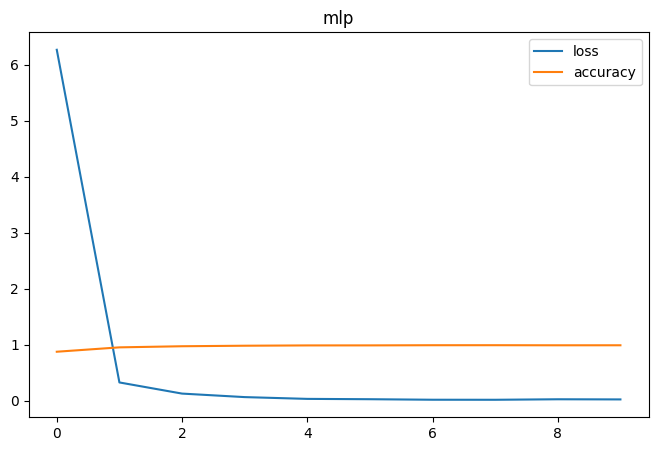

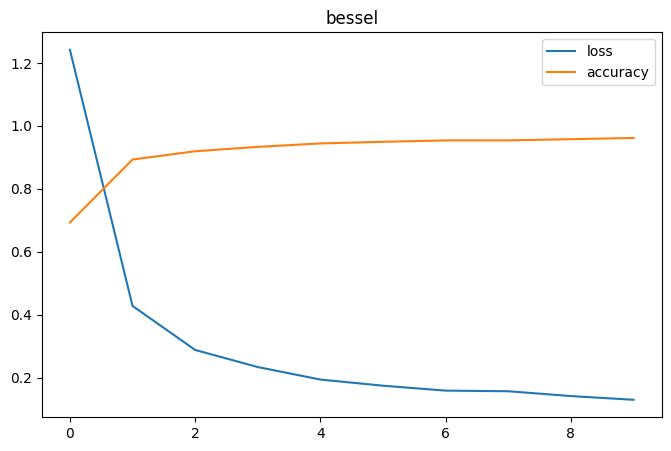

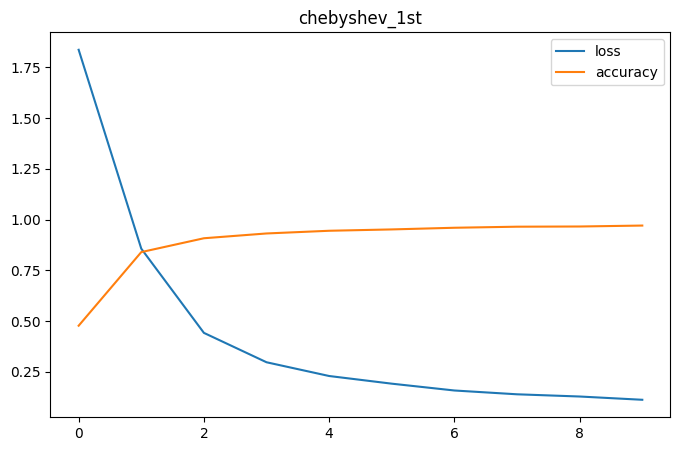

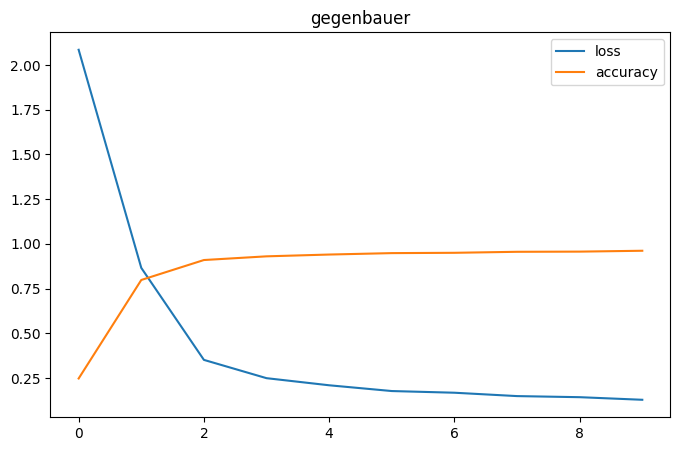

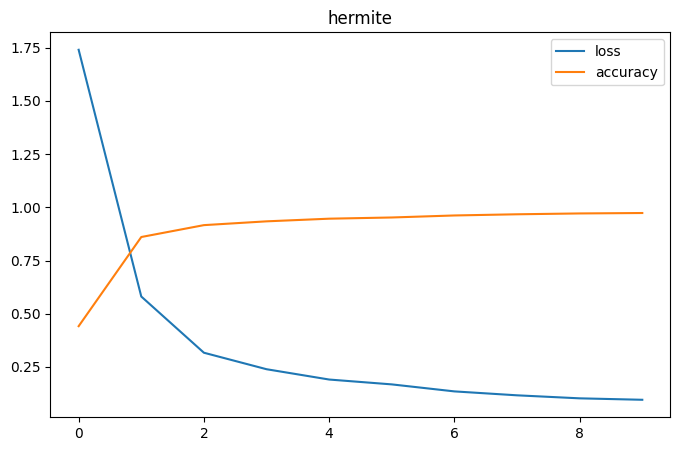

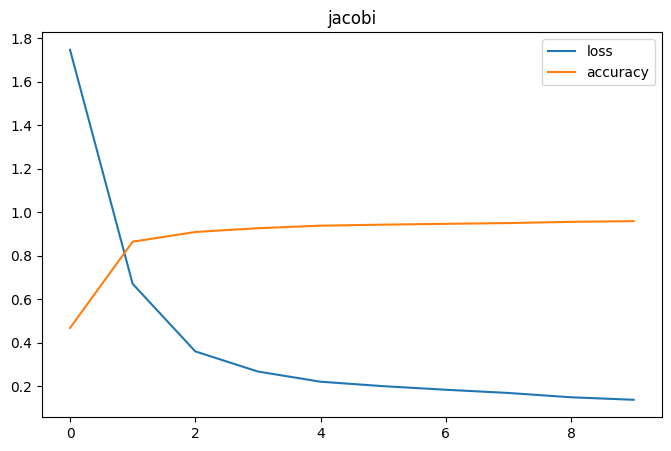

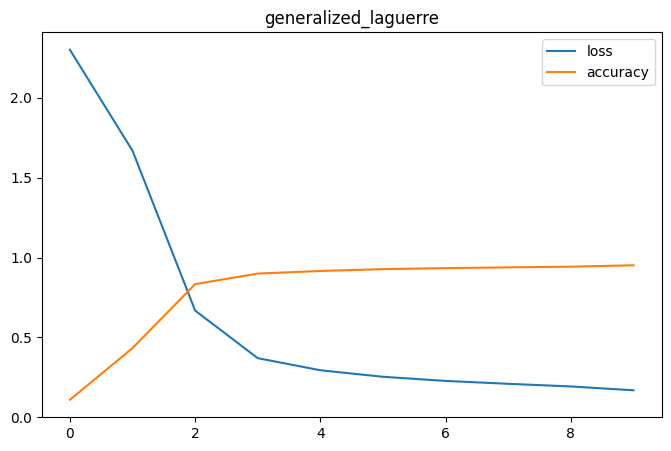

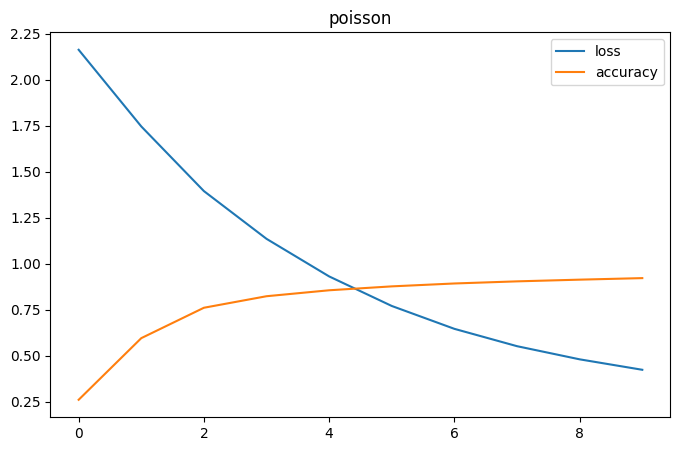

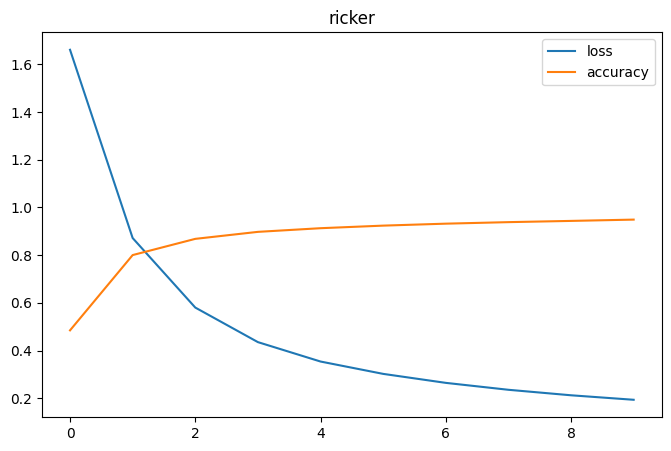

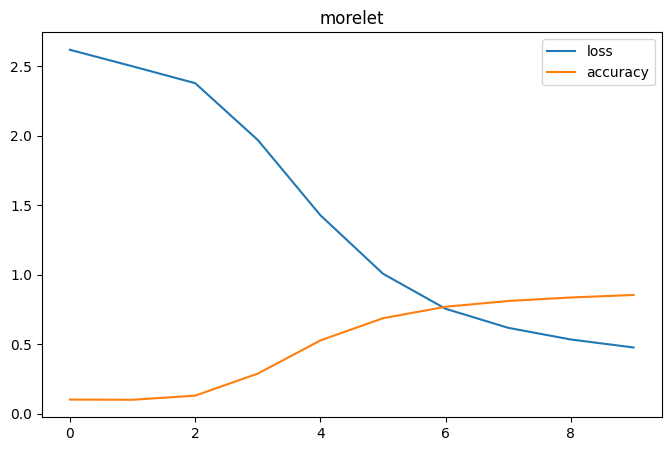

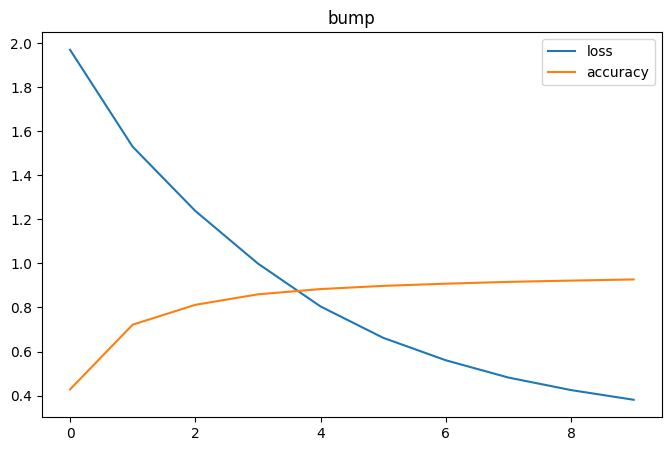

In [33]:
import pandas as pd

for name, hist in model_train_histories.items():
    pd.DataFrame(hist.history).plot(figsize=(8,5), title=name)
    plt.show()

# Evaluate against test dataset.

  0%|          | 0/11 [00:00<?, ?it/s]

20/20 [==============================] - 0s 7ms/step - loss: 0.3330 - accuracy: 0.9657


  9%|▉         | 1/11 [00:00<00:01,  7.02it/s]

20/20 [==============================] - 0s 7ms/step - loss: 0.1664 - accuracy: 0.9501


 18%|█▊        | 2/11 [00:00<00:01,  6.98it/s]

20/20 [==============================] - 0s 6ms/step - loss: 0.1486 - accuracy: 0.9561


 27%|██▋       | 3/11 [00:00<00:01,  7.51it/s]

20/20 [==============================] - 0s 8ms/step - loss: 0.1421 - accuracy: 0.9559


 36%|███▋      | 4/11 [00:00<00:00,  7.09it/s]

20/20 [==============================] - 0s 7ms/step - loss: 0.1537 - accuracy: 0.9563


 45%|████▌     | 5/11 [00:00<00:00,  7.18it/s]

20/20 [==============================] - 0s 8ms/step - loss: 0.1640 - accuracy: 0.9505


 55%|█████▍    | 6/11 [00:00<00:00,  6.82it/s]

20/20 [==============================] - 0s 8ms/step - loss: 0.1770 - accuracy: 0.9472


 64%|██████▎   | 7/11 [00:01<00:00,  6.68it/s]

20/20 [==============================] - 1s 27ms/step - loss: 0.4157 - accuracy: 0.9175


 73%|███████▎  | 8/11 [00:01<00:00,  3.60it/s]

20/20 [==============================] - 1s 29ms/step - loss: 0.2125 - accuracy: 0.9415


 82%|████████▏ | 9/11 [00:02<00:00,  2.63it/s]

20/20 [==============================] - 1s 31ms/step - loss: 0.4668 - accuracy: 0.8605


 91%|█████████ | 10/11 [00:02<00:00,  2.19it/s]

20/20 [==============================] - 0s 21ms/step - loss: 0.3698 - accuracy: 0.9260


100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


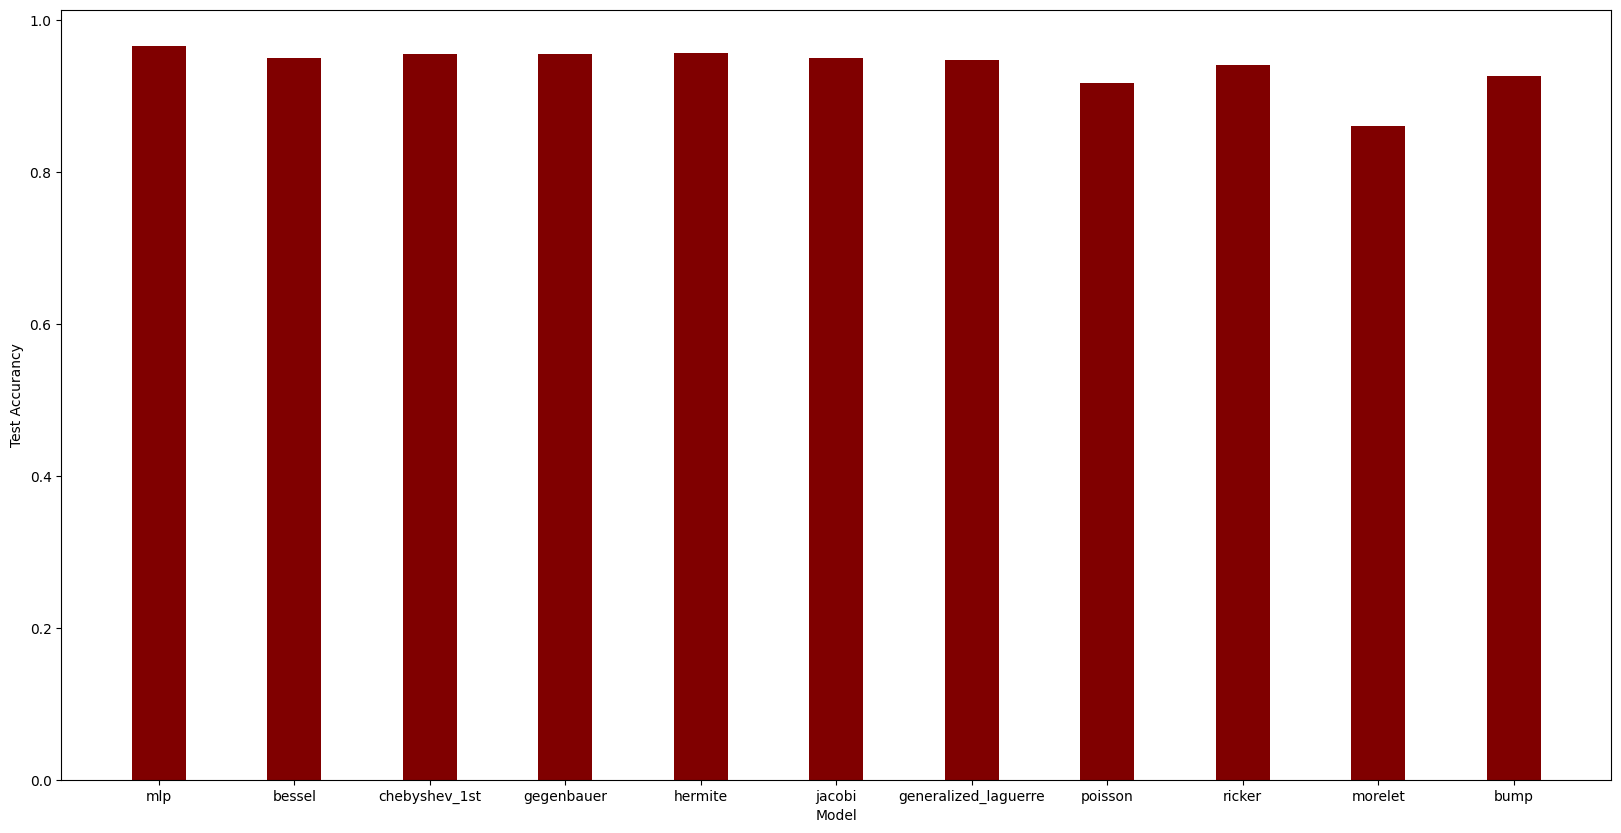

In [ ]:
all_evaluations = { name: model.evaluate(ds_test) for (name, model) in tqdm(all_models.items()) }

fig = plt.figure(figsize = (20, 10))

# creating the bar plot
plt.bar(
    list(all_evaluations.keys()), 
    np.array(list(all_evaluations.values()))[:,1],
    color ='maroon', 
    width = 0.4
)

plt.xlabel("Model")
plt.ylabel("Test Accurancy")
plt.show()

Not too bad if you keep in mind the model sizes!

In [58]:
print('Trainable parameter', {name: np.sum([np.prod(p.shape) for p in model.trainable_weights], ) for (name, model) in all_models.items()})

Trainable parameter {'mlp': 1022490, 'bessel': 77888, 'chebyshev_1st': 77888, 'gegenbauer': 77891.0, 'hermite': 77888, 'jacobi': 77894.0, 'generalized_laguerre': 77891.0, 'poisson': 77376, 'ricker': 77376, 'morelet': 77379.0, 'bump': 77376}


Let's check the confusion matrices as well...

In [36]:
y_true = np.concatenate([label for img, label in ds_test])

all_predictions = { 
    name: np.argmax(model.predict(ds_test), axis=-1) for (name, model) in tqdm(all_models.items())
}

  0%|          | 0/11 [00:00<?, ?it/s]

20/20 [==============================] - 0s 7ms/step


  9%|▉         | 1/11 [00:00<00:01,  5.58it/s]

20/20 [==============================] - 0s 7ms/step


 18%|█▊        | 2/11 [00:00<00:01,  5.17it/s]

20/20 [==============================] - 0s 6ms/step


 27%|██▋       | 3/11 [00:00<00:01,  5.35it/s]

20/20 [==============================] - 0s 7ms/step


 36%|███▋      | 4/11 [00:00<00:01,  4.98it/s]

20/20 [==============================] - 0s 7ms/step


 45%|████▌     | 5/11 [00:00<00:01,  4.93it/s]

20/20 [==============================] - 0s 8ms/step


 55%|█████▍    | 6/11 [00:01<00:01,  4.32it/s]

20/20 [==============================] - 0s 7ms/step


 64%|██████▎   | 7/11 [00:01<00:00,  4.34it/s]

20/20 [==============================] - 1s 24ms/step


 73%|███████▎  | 8/11 [00:02<00:01,  2.92it/s]

20/20 [==============================] - 1s 26ms/step


 82%|████████▏ | 9/11 [00:02<00:00,  2.31it/s]

20/20 [==============================] - 1s 26ms/step


 91%|█████████ | 10/11 [00:03<00:00,  2.04it/s]

20/20 [==============================] - 1s 21ms/step


100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


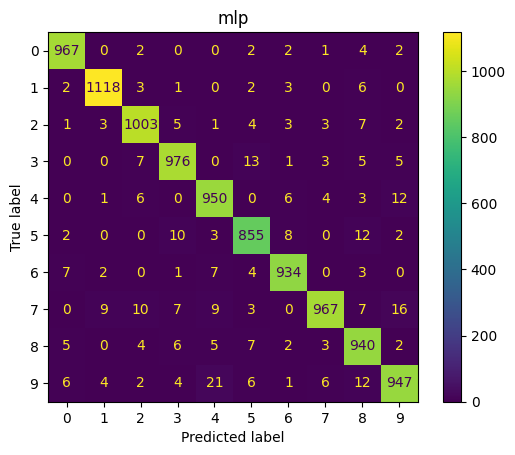

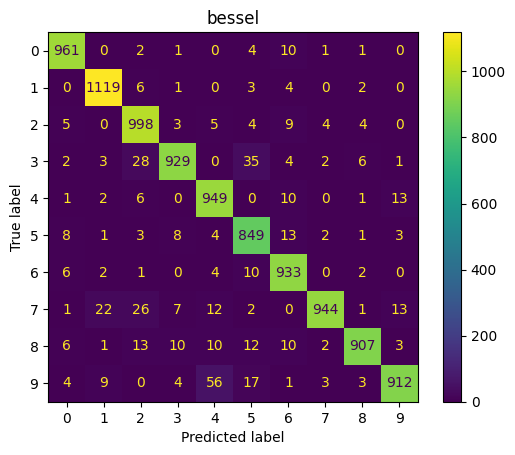

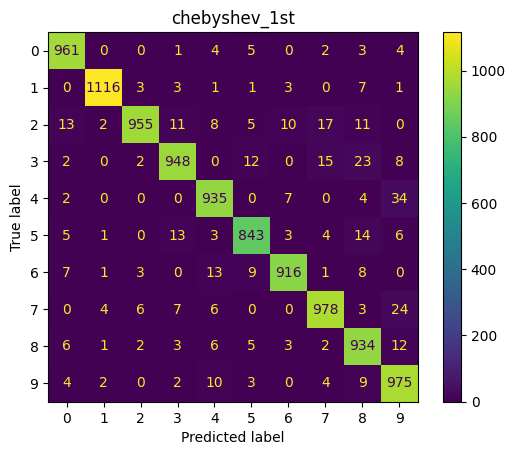

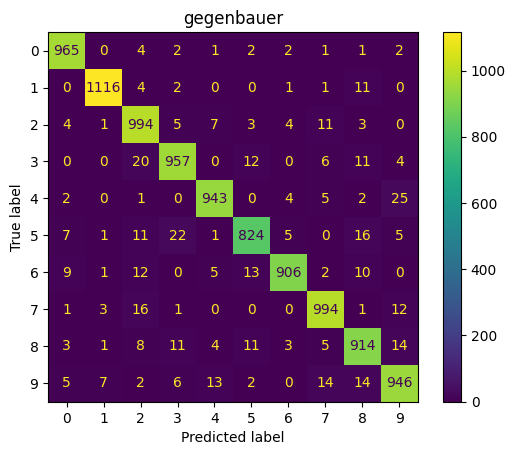

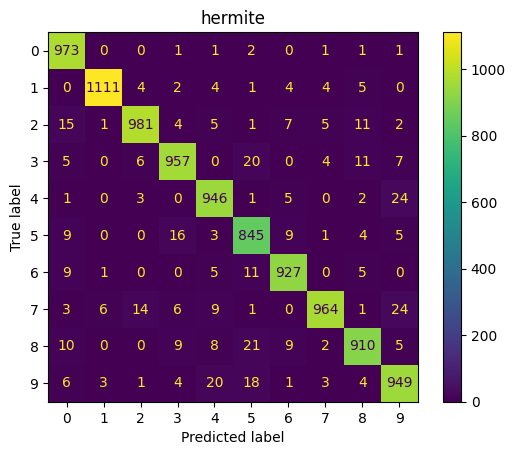

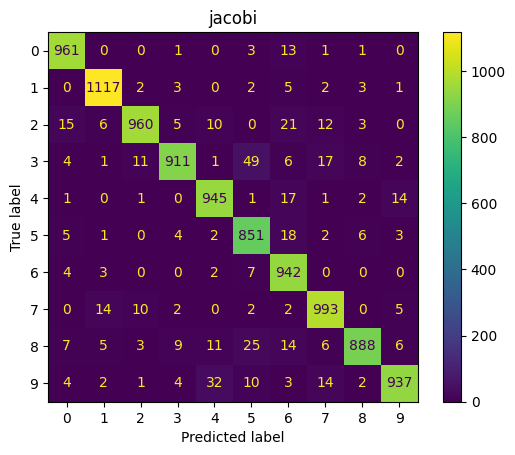

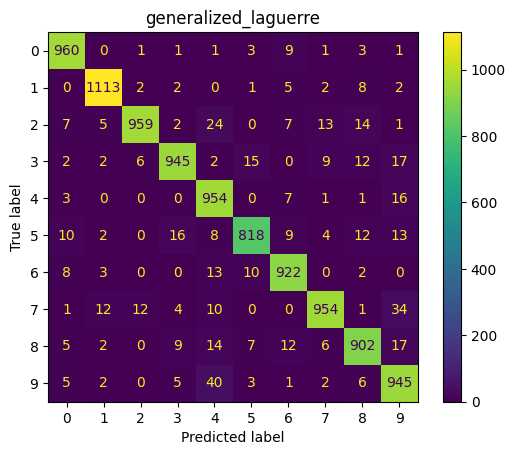

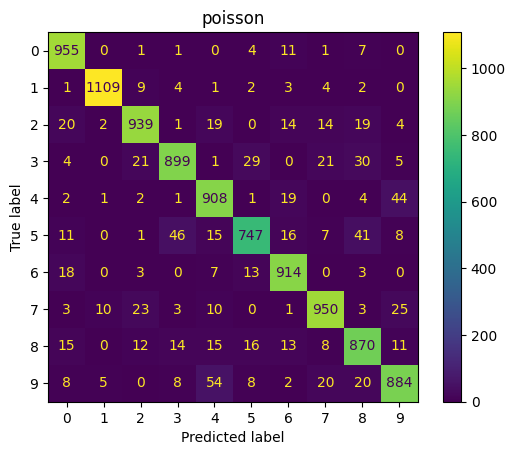

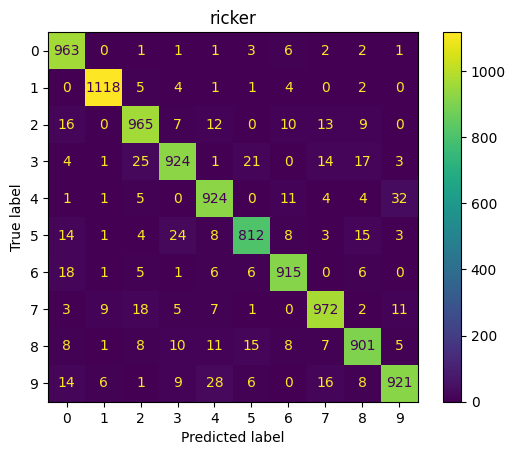

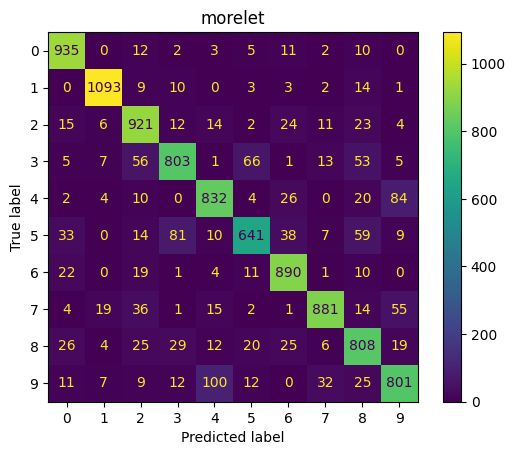

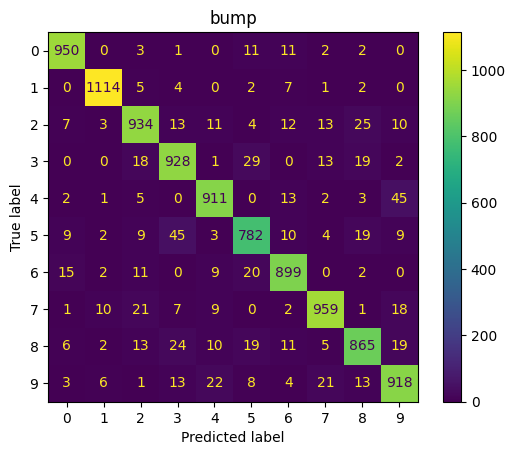

In [40]:
for name, y_pred in all_predictions.items():
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            y_true,
            y_pred,
        )
    )
    disp.plot()
    disp.ax_.set_title(name)